### Figure 5-6: Why no escape?

* Example E-I traces over a burst (train)
* E/I ratio of successive pulses across freq and numSq
* Summary figure across cells

__Note: This figure should explain why we dont see escape from E-I balance__

<img src="notes_figures/Figure_updates_Fig5_24Jan2024.jpg" height="500"/>

In [1]:
import sys
import os
import importlib
from   pathlib      import Path
import traceback

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.signal   import find_peaks, peak_widths
from scipy.signal   import butter, bessel, decimate, sosfiltfilt
from scipy.stats    import kruskal, wilcoxon, mannwhitneyu, ranksums
# from scipy.signal   import filter_design
# from scipy.optimize import curve_fit
from lmfit import Model, Parameters

# from PIL            import Image

from eidynamics     import utils, plot_tools
# ephys_classes, , expt_to_dataframe, data_quality_checks
from eidynamics     import pattern_index
# from eidynamics     import abf_to_data
# from eidynamics     import fit_PSC
# from Findsim        import tab_presyn_patterns_LR_43
# import parse_data
import all_cells
rollvar_baseline = utils.mean_at_least_rolling_variance

%matplotlib widget
%tb
# import plotly.express as px
# import plotly.graph_objects as go
# sns.set_context('paper')

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']

color_E = flare
color_I = crest
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}

Fs = 2e4
patternIDs = [46,47,48,49,50,51,52,53,54,55]

freq_sweep_pulses = np.arange(9)

>> Working on:  C:\Users\adity\OneDrive\NCBS


No traceback available to show.


In [2]:
def calculate_expected_response(celldf, pulse_index, freq, patternID, mode='p0'):
    """
    Calculate the expected response of a pattern based on the response to individual spots in the pattern
    """
    from eidynamics import pattern_index
    Fs      = 2e4
    cellID  = celldf['cellID'].iloc[0]
    # get the pattern
    constituent_spots_of_pattern    = pattern_index.get_patternIDlist_for_nSq_pattern(patternID)
    numSq                   = len(constituent_spots_of_pattern)

    # check if the given cell has 1sq data
    if not 1 in celldf['numSq'].unique():
        print('No 1Sq data for this cell', celldf['numSq'].unique())
        return numSq, pulse_index, np.nan, np.nan
    
    num_metadataframes = 28 #
    ipi                     = int(Fs / freq)
    probePulseStart         = celldf['probePulseStart'].iloc[0] # 0.2
    pulseTrainStart         = celldf['pulseTrainStart'].iloc[0] # 0.5 
    pulse_start_times       = [int(Fs*probePulseStart)]
    pulse_start_times.extend((Fs * utils.get_pulse_times(8,pulseTrainStart,freq)).astype(int))
    pulse_start_times       = np.array(pulse_start_times)
    pulse_end_times         = pulse_start_times + ipi
    t0, t1                  = pulse_start_times[pulse_index], pulse_end_times[pulse_index]

    # slice the dataframe to get the response to the given pattern
    celldf                          = celldf.loc[:, ~celldf.columns.isin(celldf.columns[28:49])]
    celldf.loc[:, 'patternList']    = celldf['patternList'].astype('int32')
    pattern_response_df             = celldf[(celldf['patternList'] == patternID) & (celldf['stimFreq'] == freq)  ]
    
    if pattern_response_df.shape[0] == 0:
        print('No data for this pattern and freq')
        return numSq, pulse_index, np.nan, np.nan
           
    # to get the expected response we have to add the average responses to each individual spot in the pattern
    # individual patterns are in the list 'constituent_spots_of_pattern'.
    # step1: slice the dataframe to get only those rows where 'patternList' is in the list 'constituent_spots_of_pattern'
    # step2: get the peaks for each row between columns probePulseStart and probePulseStart+ipi
    # step3: average the peaks across 3 trials for each pattern and then sum them up to get the expected response
    # Do this using pandas slicing methods rather than a for loop wherever possible

    # step 0: get the observed response from the pattern_response_df
    observed_response = pattern_response_df.iloc[:, t0:t1].max(axis=1).values
    # assert observed_response.shape[0] == 3, "Observed response should have 3 trials"

    # step 1: slice the dataframe to get only those rows where 'patternList' is in the list 'constituent_spots_of_pattern'
    df_temp = celldf.loc[celldf['patternList'].isin(constituent_spots_of_pattern), :].copy()
    
    # step 2: get the peaks for each row between columns probePulseStart and probePulseStart+ipi
    whole_trace = df_temp.iloc[:, 28:20028].to_numpy()

    traces = df_temp.iloc[:, 28+pulse_start_times[0]:28+pulse_end_times[0]].to_numpy()
    # subtrace baseline value for each of the rows in traces array
    baseline = np.mean(whole_trace[:, :2000], axis=1)
    traces = (traces.T - baseline).T
    df_temp.loc[:, 'peaks'] = np.max(traces, axis=1) #rollvar_baseline
    df_temp['peaks'] = pd.to_numeric(df_temp['peaks'])  # Convert 'peaks' column to numeric data type
    expected_response_0 = df_temp.loc[:,('patternList','peaks')].groupby(by='patternList').mean().sum()['peaks']

    traces = df_temp.iloc[:, 28+t0:28+t1].to_numpy()
    # subtrace baseline value for each of the rows in traces array
    baseline = np.mean(whole_trace[:, :2000], axis=1)
    traces = (traces.T - baseline).T
    df_temp.loc[:, 'peaks'] = np.max(traces, axis=1) #rollvar_baseline
    # step 3: average the 'peaks' across 3 trials for each pattern and then sum them up to get the expected response
    df_temp['peaks'] = pd.to_numeric(df_temp['peaks'])  # Convert 'peaks' column to numeric data type
    expected_response_n = df_temp.loc[:,('patternList','peaks')].groupby(by='patternList').mean().sum()['peaks']
    

    return numSq, pulse_index, np.mean(observed_response), expected_response_0, expected_response_n

### Steps:
1. Write a function to get expected response for P0 for a given pattern.
2. Get the expected response for each pattern.
3. Plot the expected response vs observed response coloured according to the numSq in each pattern.

In [2]:
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figure5")
data_path                    = Path(r"parsed_data\\")
cell_data_path               = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\Screened_cells\\")

In [28]:
# Full data set for FreqSweep protocol (df) (raw dataframe with metadata)
freq_sweep_cc_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_CC_long.h5" 
# freq_sweep_vc_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_VC_long.h5" 
df = pd.read_hdf(freq_sweep_cc_datapath, key='data')

# print new size of dataframe
print(f"Full FreqSweep Dataframe has {df.shape[0]} sweeps")

dfslice = df[
            (df['location'] == 'CA1') &
            (df['numSq'].isin([1,5,15])) &
            # (df['AP'] == 0) &
            (df['IR'] >50) & (df['IR'] < 300) &
            (df['tau'] < 0.05) & (df['tau'] > 0) &
            (df['intensity'] == 100) &
            # (df['pulseWidth'] == 2) &
            # (df['sweepBaseline'] < -50) &
            (df['condition'] == 'Control') &
            (df['ch0_response']==1) #&
            # (df['spike_in_stim_period'] == 0) &
            # (df['spike_in_baseline_period'] == 0) &
            # (df['ac_noise_power_in_ch0'] < 20) 
        ]

# del df

Full FreqSweep Dataframe has 4971 sweeps


In [29]:
# turn 'SpikingFlag' column values to 0 or 1 depending on whether the maximum of col 49:20049 is greater than 20
dfslice.loc[:, 'SpikingFlag'] = (dfslice.iloc[:, 49:20049].max(axis=1) > 20).astype(int)

C:\Users\adity\AppData\Local\Temp\ipykernel_26476\1633488665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfslice.loc[:, 'SpikingFlag'] = (dfslice.iloc[:, 49:20049].max(axis=1) > 20).astype(int)


In [31]:
# get the sweeps for which spikingFlag was 1
APdf = dfslice[(dfslice['SpikingFlag'] == 1)]
APcells = APdf['cellID'].unique()
APdf.shape

(194, 80074)

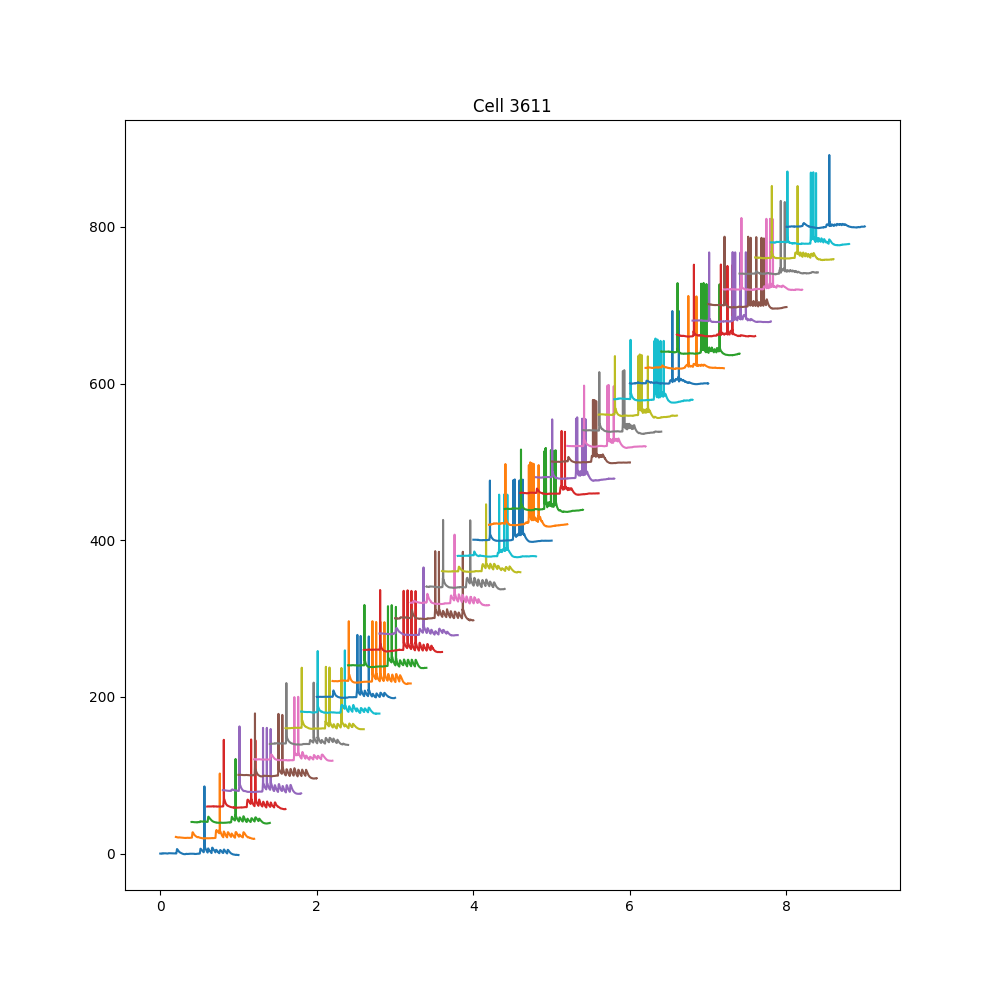

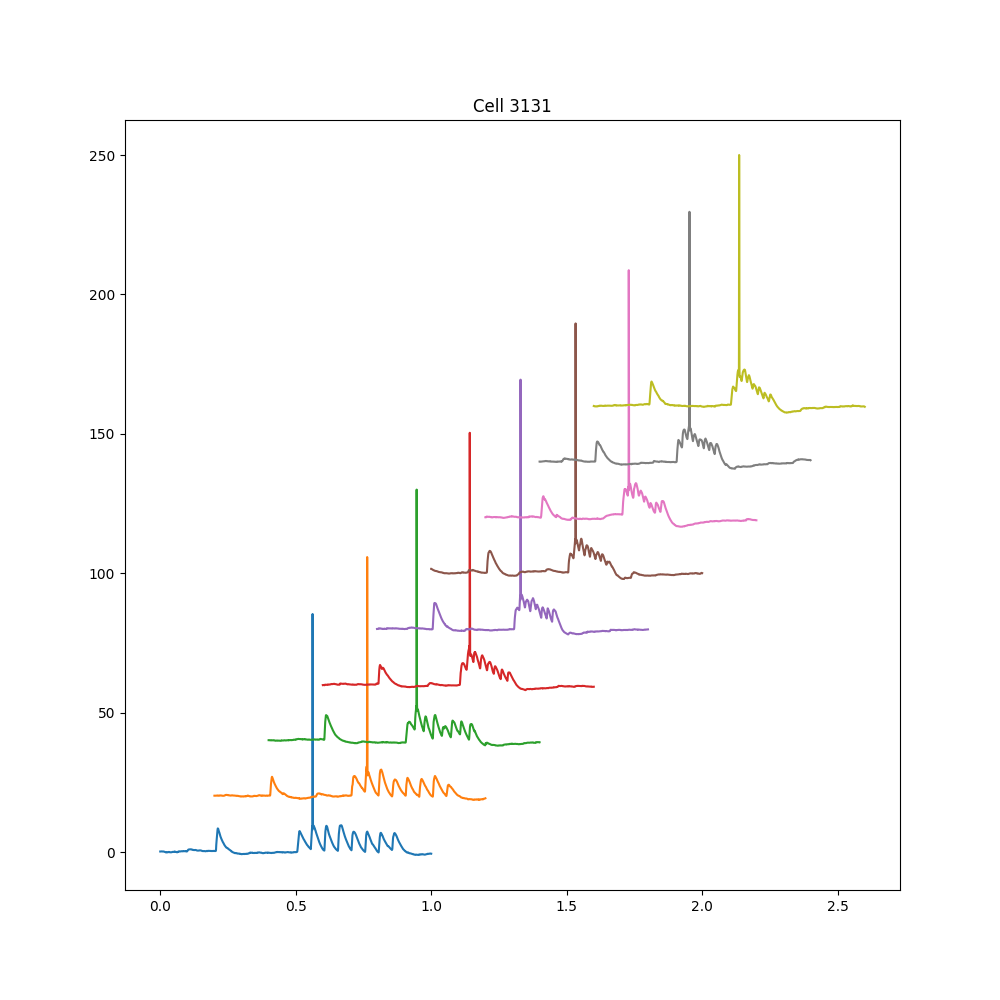

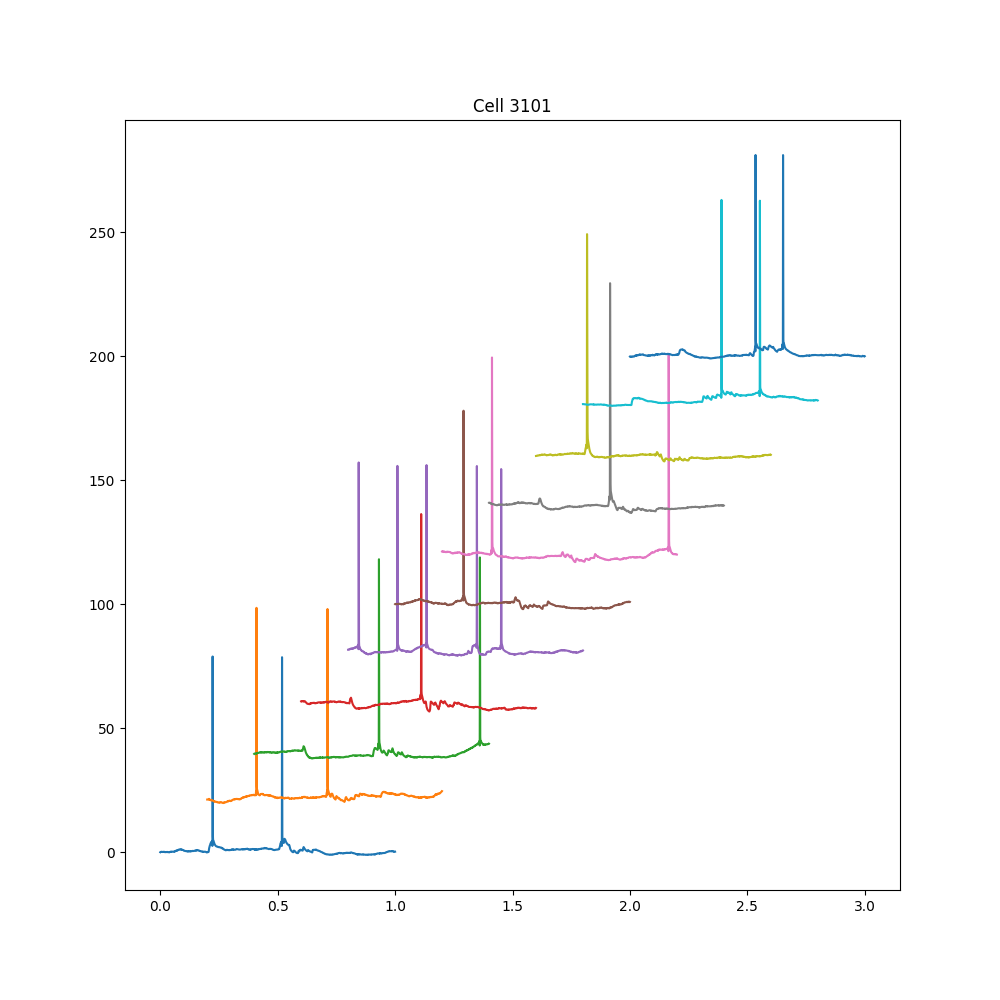

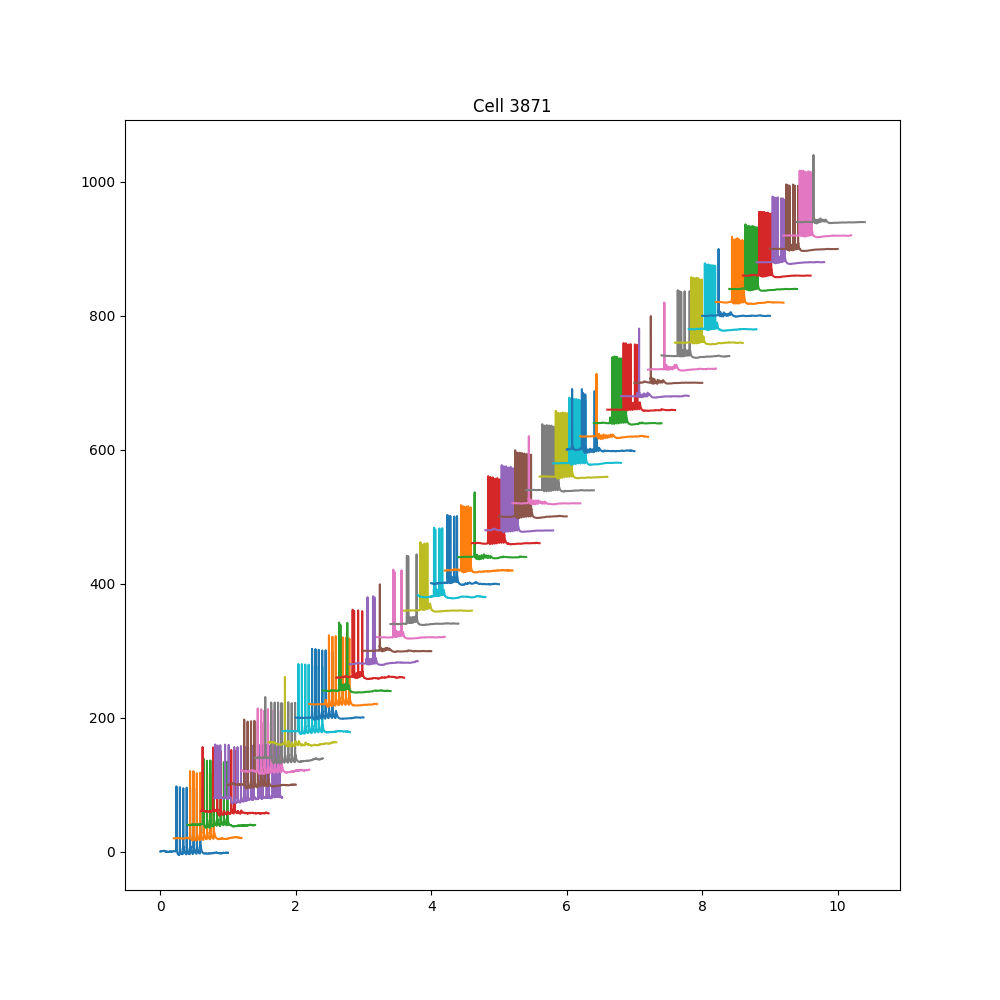

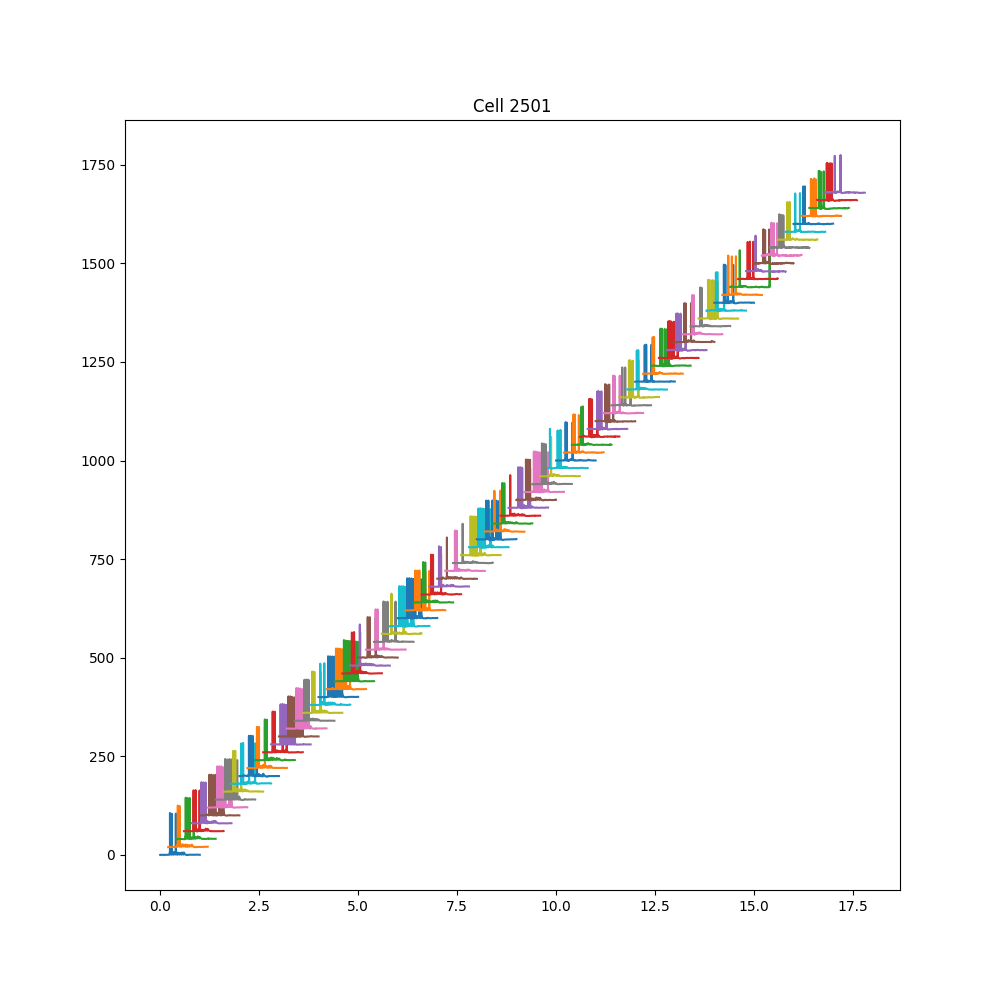

In [26]:

for j,apcell in enumerate(APcells):
    celldf = APdf[APdf['cellID'] == apcell]
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    for i,tid in enumerate(np.sort(celldf['trialID'])):
        ax.plot(0.20*i+np.linspace(0,1,20000), 20*i+celldf[celldf['trialID'] == tid].iloc[0, 49:20049])
    ax.set_title(f"Cell {apcell}")

In [32]:
# find if any of these APcells have 1sq data
allAPcellsdata = dfslice[dfslice['cellID'].isin(APcells)]
allAPcellsdata.shape

(364, 80074)

In [ ]:
# for each cell in sq1 cells, get the unique exptIDs
sq1_exptIDs = {}
for cell in allAPcellsdata['cellID'].unique():
    sq1_exptIDs[cell] = dfslice[(dfslice['cellID'] == cell) & (dfslice['numSq'] == 1)]['exptID'].unique()
    

In [ ]:
sq1_exptIDs

In [ ]:
# create a dataframe with columns: cellID, patternID, numSq, freq, observed response, expected response
# for each cell, pattern, freq combination
# this dataframe will be used to calculate the response index
# first create an empty dataframe with the required columns
cc_cells = list(sq1_exptIDs.keys())    #cc_FS_longdf['cellID'].unique()
# df_sdn = pd.DataFrame(columns=['cellID', 'patternID', 'numSq', 'freq', 'pulse_index', 'observed_response', 'expected_response'])

expected_data = []
counter = 0
error_counter = 0
# loop through each cell in the main dataframe xx_FS_longdf
for cellID in cc_cells:
    # get the dataframe for the given cell
    celldf = dfslice[dfslice['cellID']==cellID].copy()
    
    # loop through each pattern
    for patternID in patternIDs:
        if patternID>45:
            # loop through each frequency
            for freq in celldf['stimFreq'].unique():
                # loop through each pulse
                for pulse_index in range(9):
                    print(celldf.shape, pulse_index, freq, patternID)
                    # calculate the expected response, outputs :cellID, patternID, numSq, pulse_index, np.mean(observed_response), expected_response
                    try:
                        numSq, pulse_index, observed_response, expected_response_0, expected_response_n = calculate_expected_response(celldf, pulse_index, freq, patternID)
                        # append the data to a list of dicts called expected_data
                        expected_data.append({'cellID':cellID, 'patternID':patternID, 'numSq':numSq, 'freq':freq, 'pulse_index':pulse_index, 'observed_response':observed_response, 'expected_response_0':expected_response_0, 'expected_response_n':expected_response_n})
                        counter += 1
                    except Exception as e:
                        print(f'Error in calculating expected response for cell {cellID}, pattern {patternID}, freq {freq}, pulse {pulse_index}')
                        print(e)
                        # print traceback
                        print(traceback.format_exc())
                        error_counter += 1
                        continue
                    
                    print(counter, error_counter, len(expected_data))

# create a dataframe from the list of dicts
df_sdn = pd.DataFrame(expected_data)

In [3]:
df_sdn = pd.read_hdf(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\df_sdn.h5", key='data')

In [41]:
df_sdn.head(10)

cellID  patternID  numSq  freq  pulse_index  observed_response  \
0    4041         46      5    20            0           2.982699   
1    4041         46      5    20            1           3.444287   
2    4041         46      5    20            2           5.818438   
3    4041         46      5    20            3           6.553988   
4    4041         46      5    20            4           5.351973   
5    4041         46      5    20            5           2.829030   
6    4041         46      5    20            6           3.209641   
7    4041         46      5    20            7           2.444784   
8    4041         46      5    20            8           1.993364   
9    4041         46      5    50            0           3.898606   

   expected_response_0  expected_response_n  
0             0.844526             0.844526  
1             0.844526             0.813087  
2             0.844526             1.735424  
3             0.844526             1.617761  
4             0.844526             0.976876  
5             0.844526             1.193335  
6             0.844526             2.214606  
7             0.844526             1.958215  
8             0.844526             0.751962  
9             0.074725             0.074725

<Axes: xlabel='expected_response_n', ylabel='observed_response'>

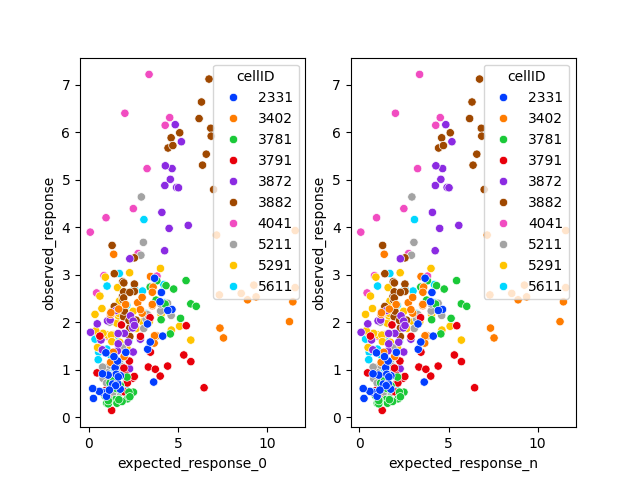

In [5]:
fig, [ax1, ax2] = plt.subplots(1,2)
sns.scatterplot(data=df_sdn[df_sdn['pulse_index']==0], x='expected_response_0', y='observed_response', hue='cellID', palette='bright',ax=ax1)
sns.scatterplot(data=df_sdn[df_sdn['pulse_index']==0], x='expected_response_n', y='observed_response', hue='cellID', palette='bright',ax=ax2)
# save figs
# fig.savefig(paper_figure_export_location / 'expected_vs_observed_response.png', dpi=300)

(0.0, 12.0)

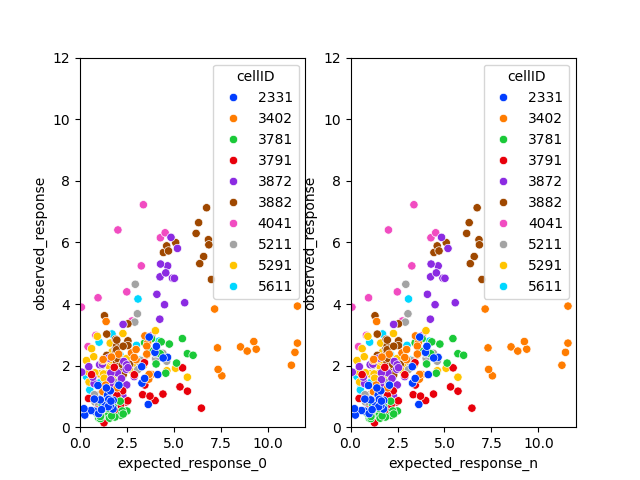

In [9]:
fig, [ax1, ax2] = plt.subplots(1,2)
sns.scatterplot(data=df_sdn[df_sdn['pulse_index']==0], x='expected_response_0', y='observed_response', hue='cellID', palette='bright',ax=ax1)
sns.scatterplot(data=df_sdn[df_sdn['pulse_index']==0], x='expected_response_n', y='observed_response', hue='cellID', palette='bright',ax=ax2)
ax1.set_xlim([0,12])
ax1.set_ylim([0,12])
ax2.set_xlim([0,12])
ax2.set_ylim([0,12])

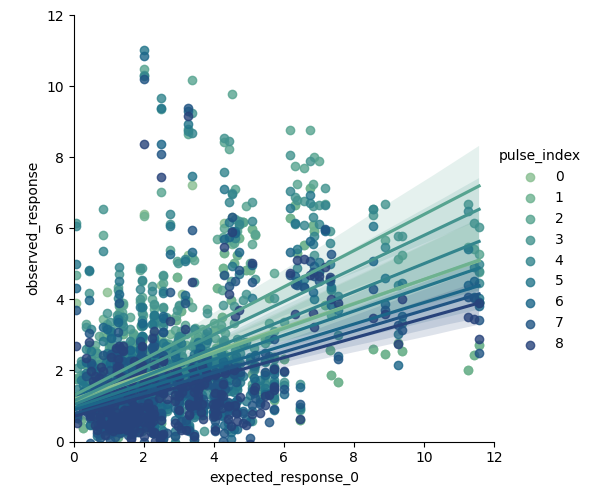

In [13]:

lm = sns.lmplot(data=df_sdn, x='expected_response_0', y='observed_response', hue='pulse_index', palette='crest')
lm.set(xlim=(0, 12), ylim=(0, 12))


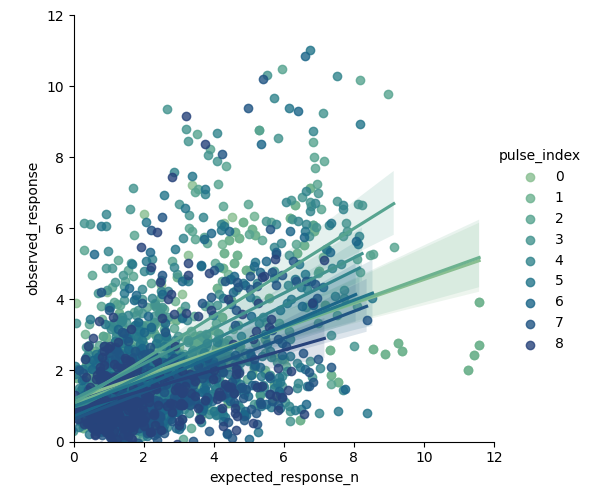

In [11]:

lm = sns.lmplot(data=df_sdn, x='expected_response_n', y='observed_response', hue='pulse_index', palette='crest')
lm.set(xlim=(0, 12), ylim=(0, 12))


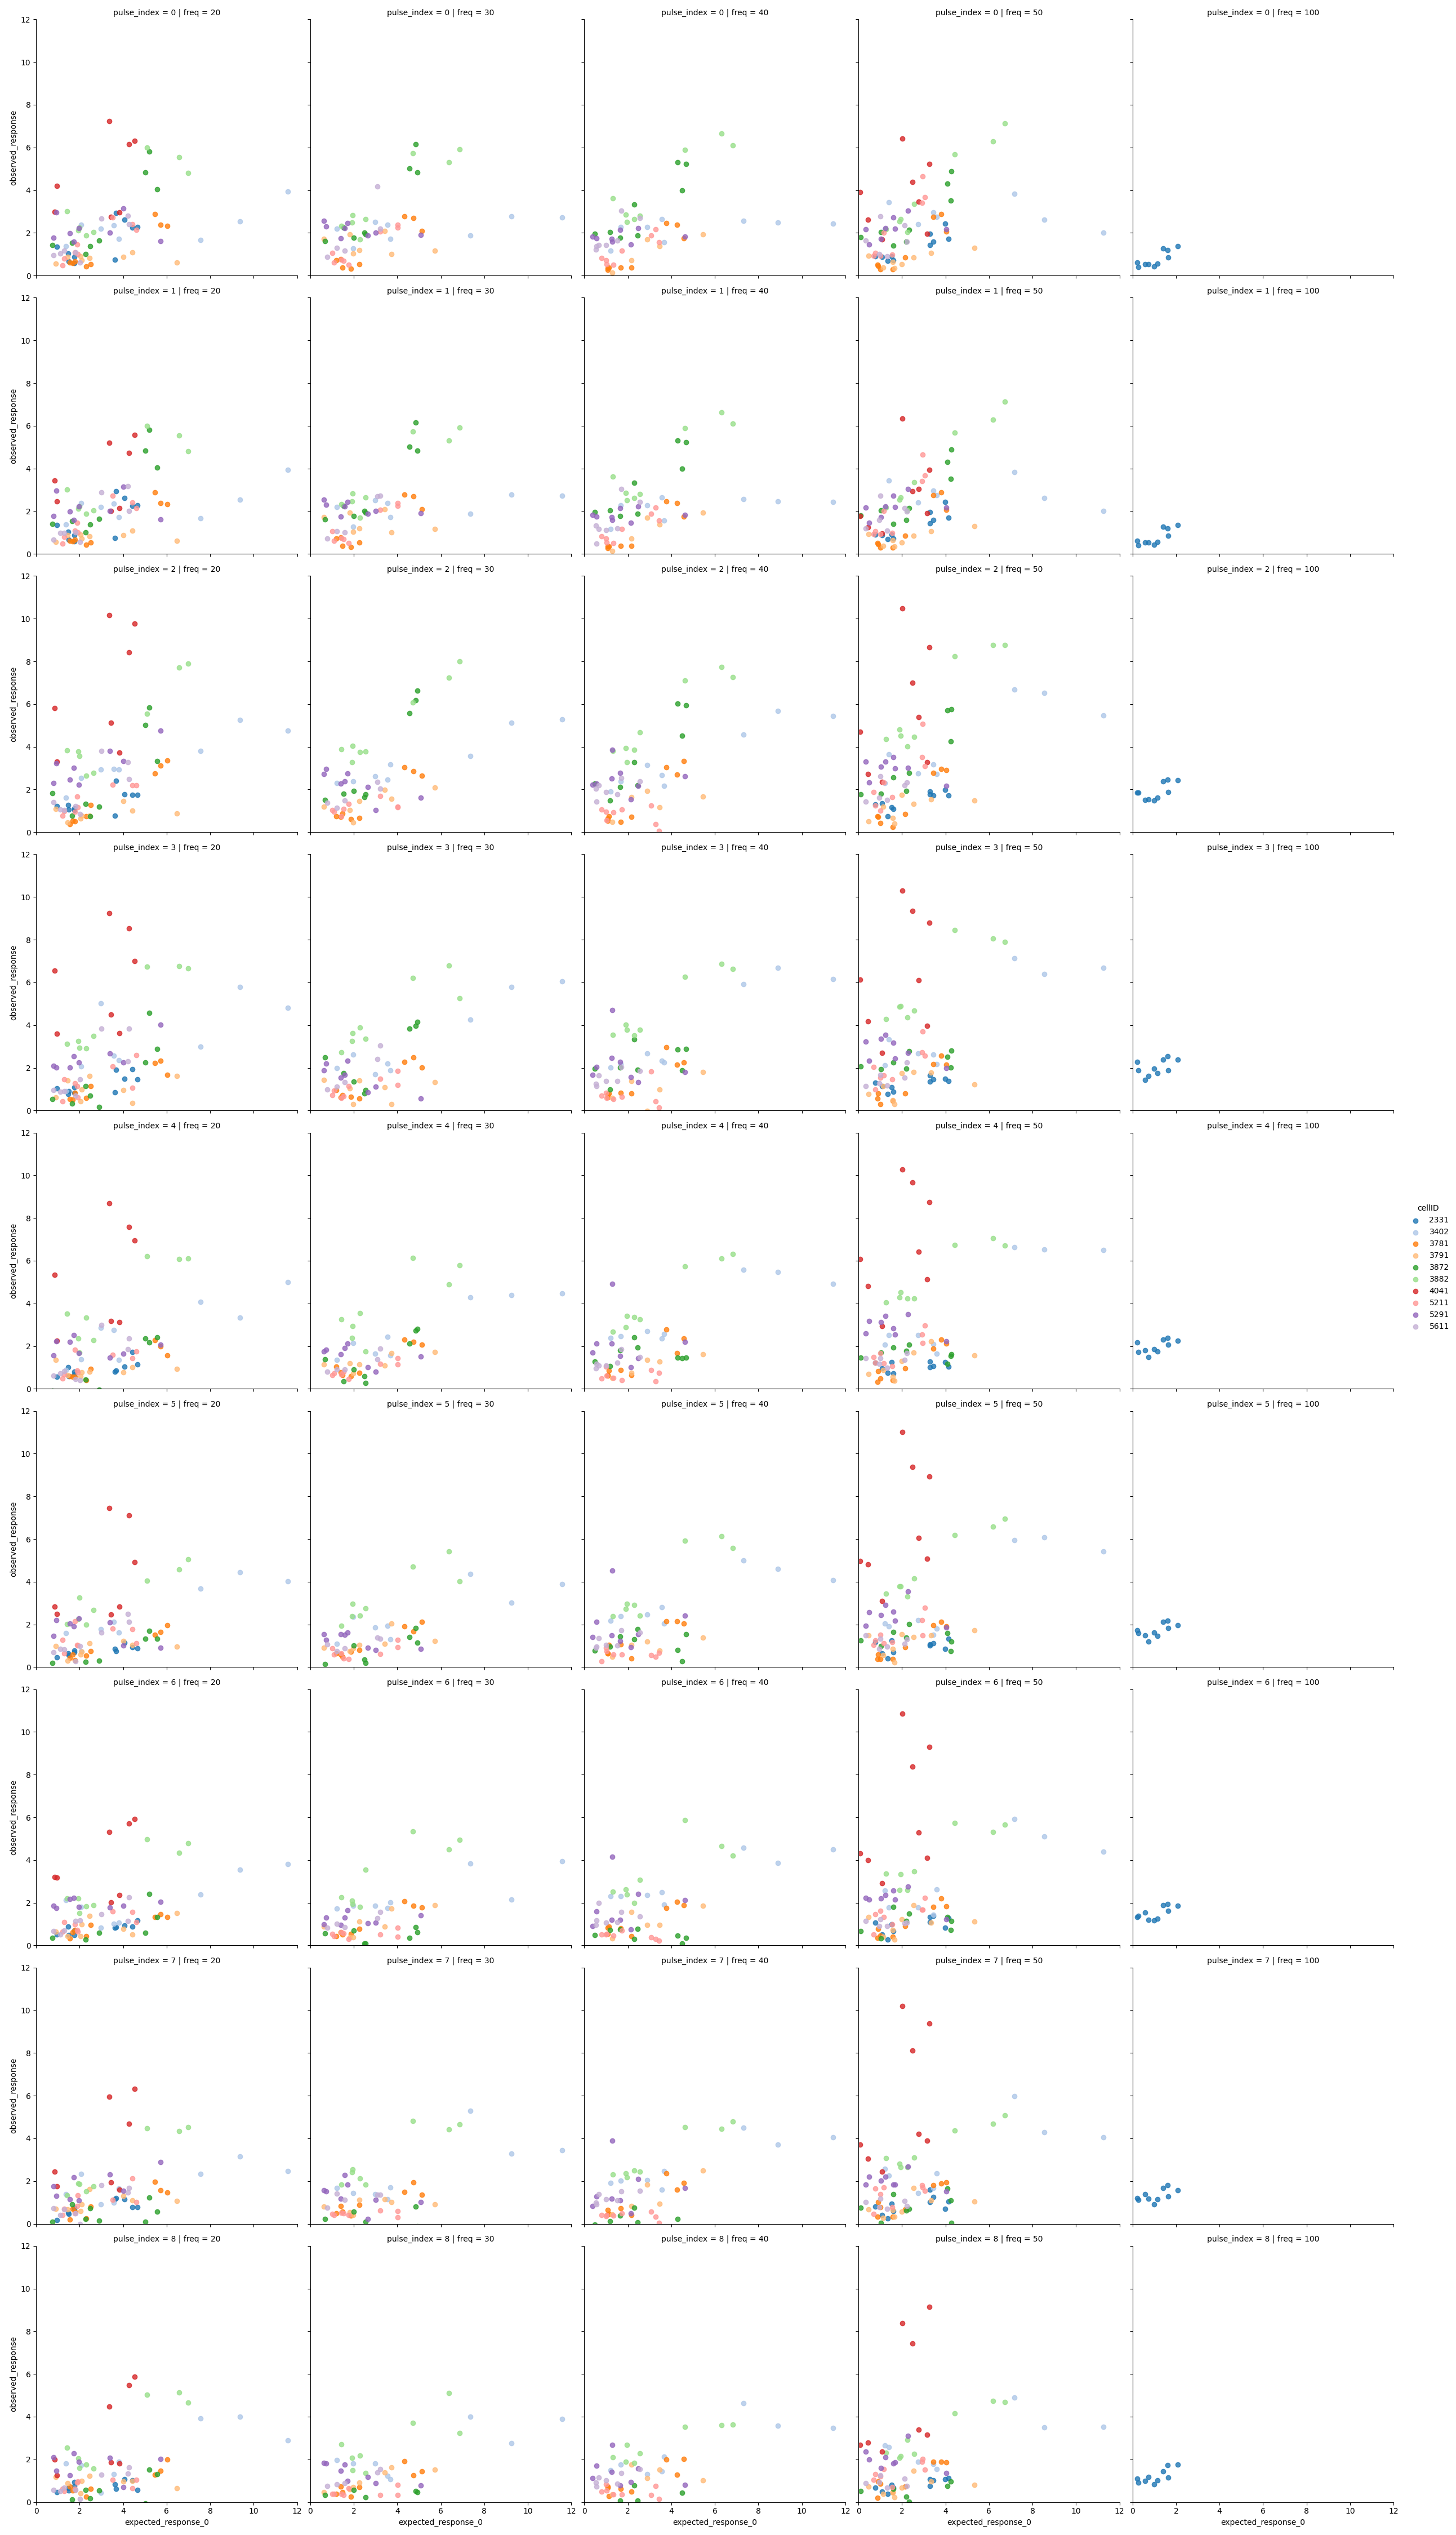

In [46]:

plt.close('all')
lm = sns.lmplot(data=df_sdn, x='expected_response_0', y='observed_response', row='pulse_index', col='freq', hue='cellID', palette='tab20', fit_reg=False)
lm.set(xlim=(0, 12), ylim=(0, 12))

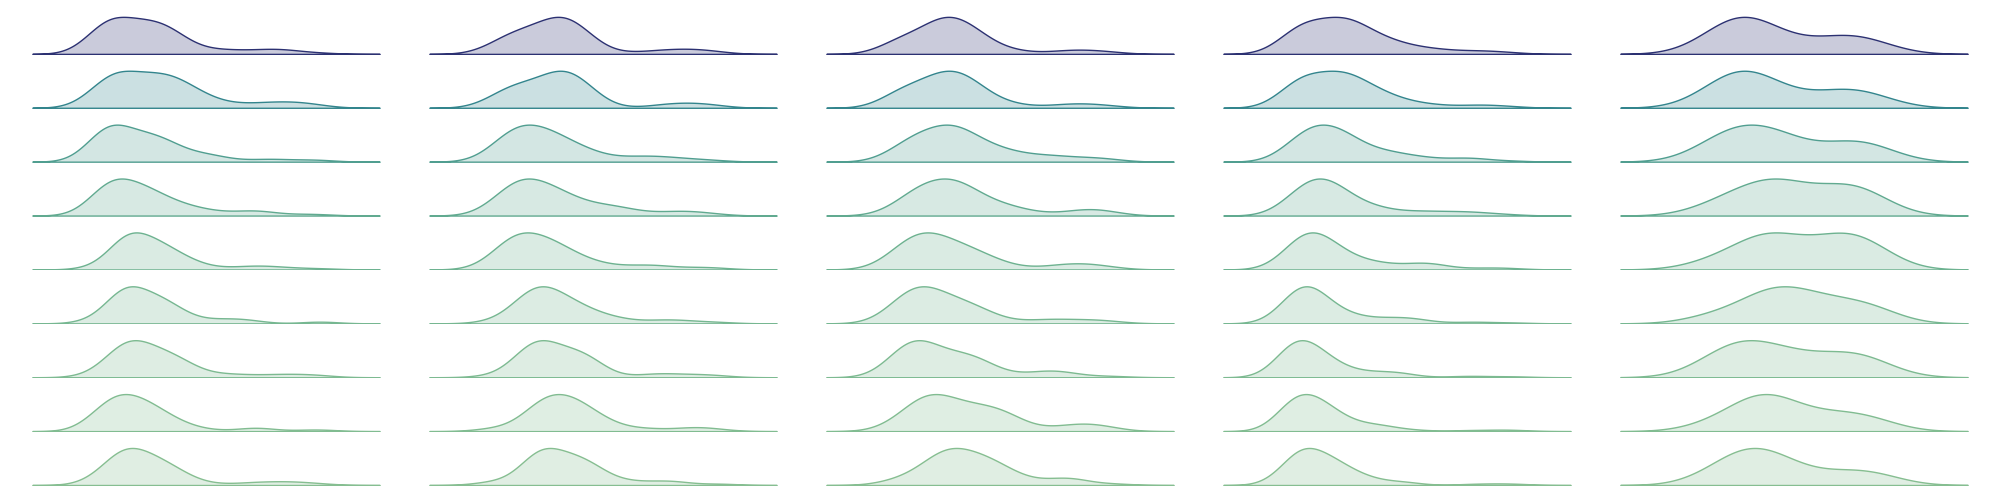

In [83]:
fig, ax = plt.subplots(9,5, figsize=(20,5))
crest   = mpl.colormaps["crest"]
freqs = df_sdn['freq'].unique()
# sort freq
freqs = np.sort(freqs)
for i, freq in enumerate(freqs):
    for j in range(9):
        sns.kdeplot(data=df_sdn[(df_sdn['freq']==freq)&(df_sdn['pulse_index']==j)], x='observed_response', color=crest(1/(1+j)), ax=ax[j,i], fill=True, common_norm=False)
        # remove legend
        ax[j,i].legend([], [], frameon=False)
        # remove y axis
        ax[j,i].set_ylabel('')
        # remove x axis
        ax[j,i].set_xlabel('')
        # remove title
        ax[j,i].set_title('')
        # remove x spline
        ax[j,i].spines['top'].set_visible(False)
        ax[j,i].spines['right'].set_visible(False)
        ax[j,i].spines['left'].set_visible(False)
        ax[j,i].spines['bottom'].set_visible(False)
        # remove ticks
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])
# change the spacing to compact
fig.tight_layout()

# save figs
# fig.savefig(paper_figure_export_location / 'observed_response_kde.png', dpi=300)

In [ ]:
g = np.tile(list("0123456789"), 50)

# Initialize the FacetGrid object
pal = 'crest' #sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_sdn, row="pulse_index", hue="pulse_index", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "gamma",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "gamma", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color, fontsize=8,  
                  ha="left", va="center", transform=ax.transAxes, zorder=10)

g.map(label, "gamma")

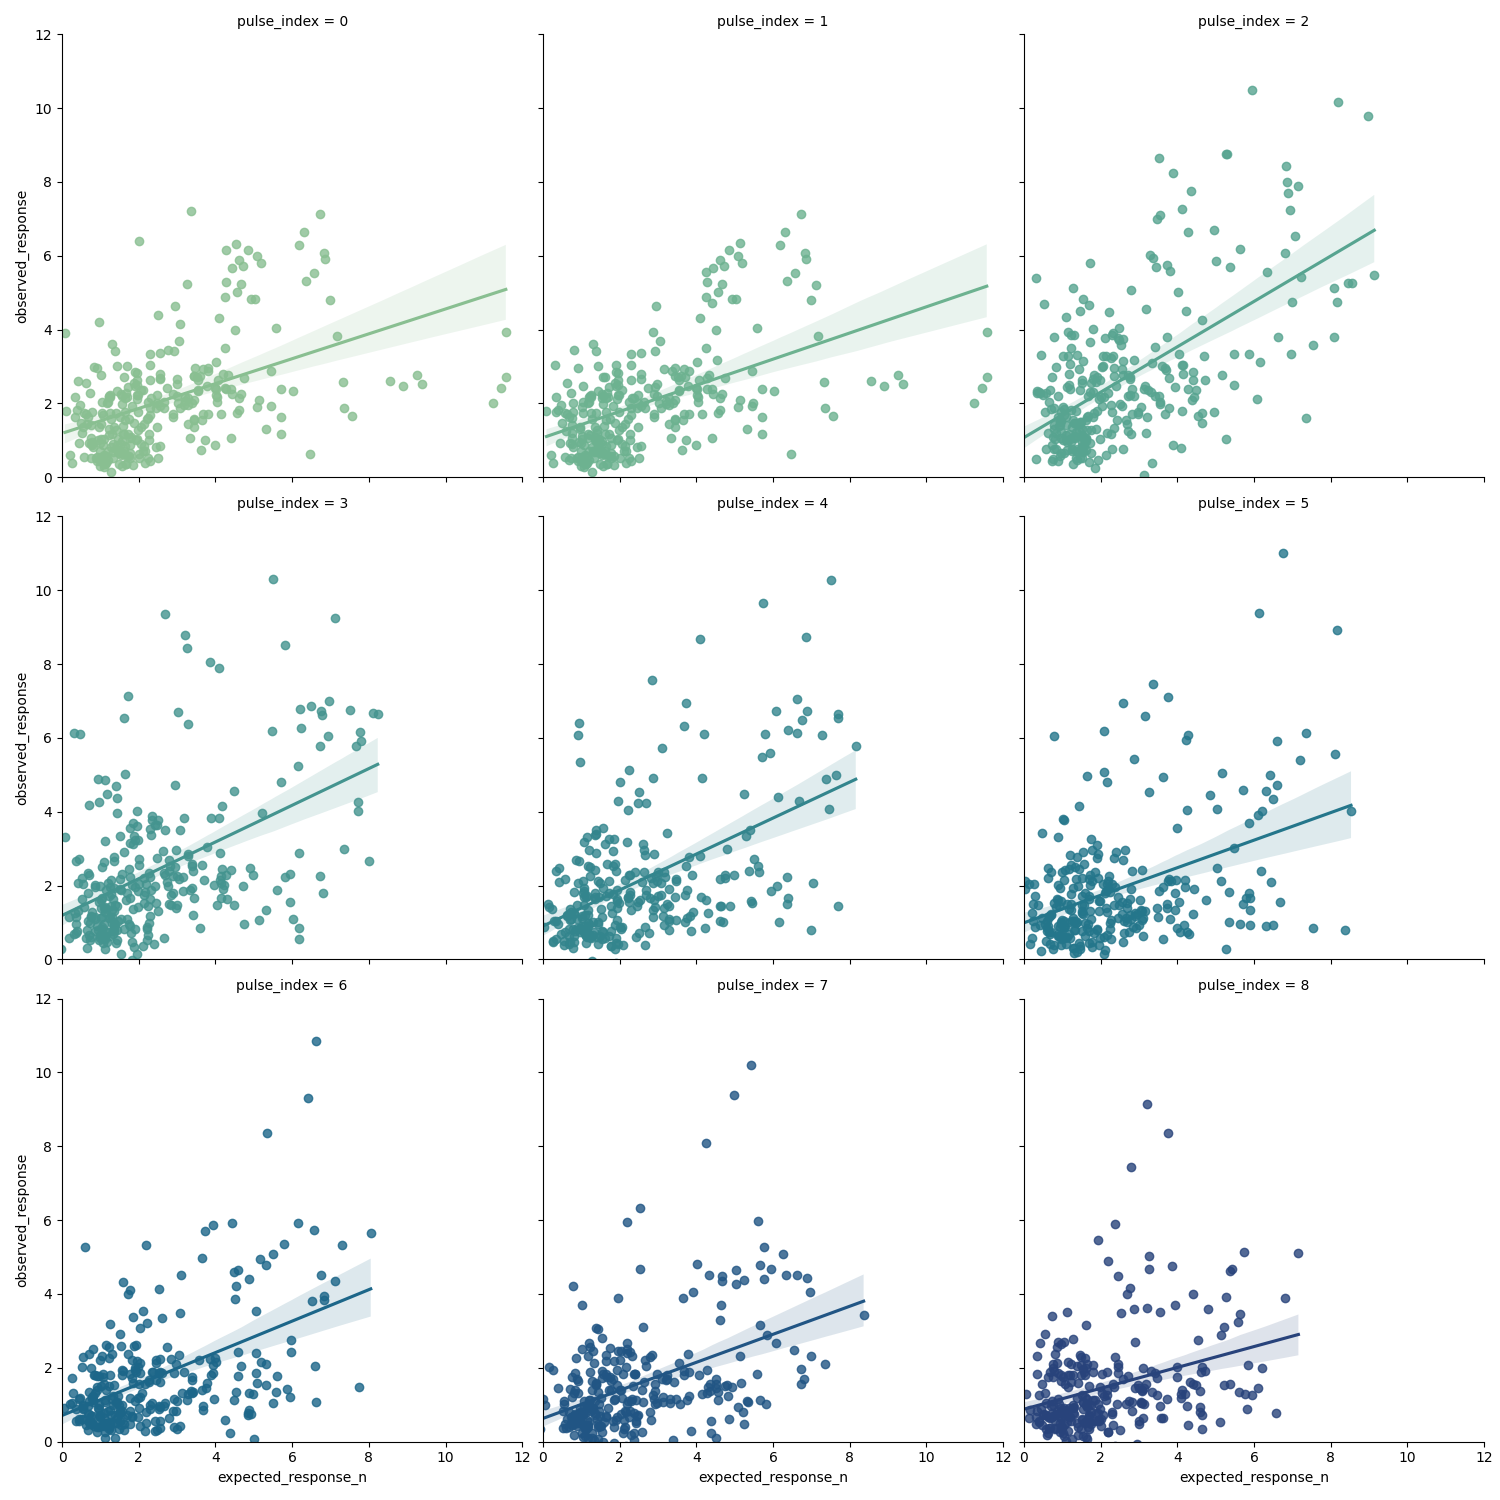

In [64]:
lm = sns.lmplot(data=df_sdn, x='expected_response_n', y='observed_response', col='pulse_index', col_wrap=3, hue='pulse_index', palette='crest')
lm.set(xlim=(0, 12), ylim=(0, 12))

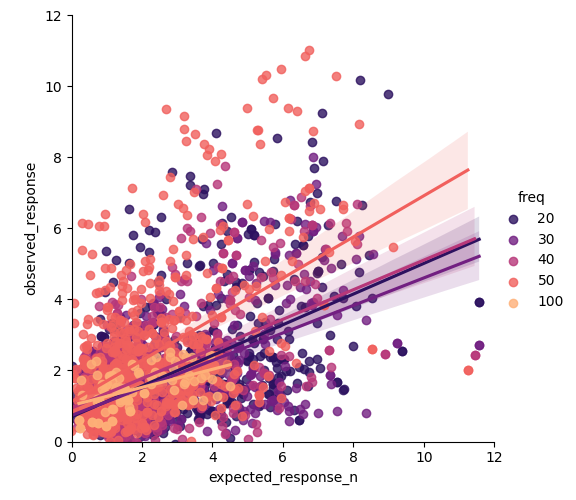

In [12]:
lm2 = sns.lmplot(data=df_sdn, x='expected_response_n', y='observed_response', hue='freq', palette='magma')
lm2.set(xlim=(0, 12), ylim=(0, 12))

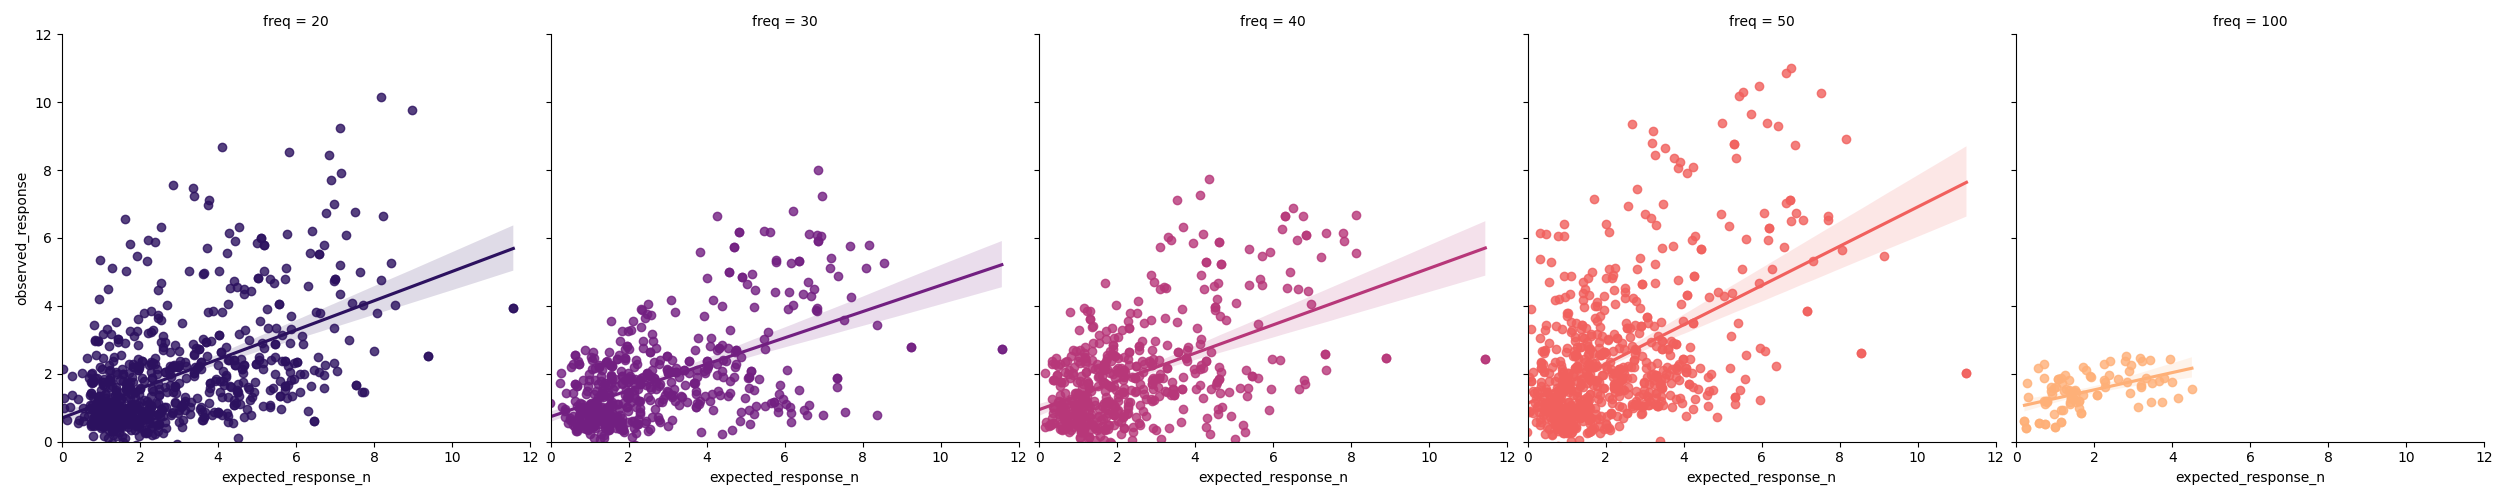

In [19]:
lm2 = sns.lmplot(data=df_sdn, x='expected_response_n', col='freq', y='observed_response', hue='freq', palette='magma')
lm2.set(xlim=(0, 12), ylim=(0, 12))

In [ ]:
# save df_sdn to a file
df_sdn.to_hdf(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\df_sdn.h5", key='data')

In [ ]:
def sdnfunc(x, gamma):
    return gamma * x / (gamma + x)

def nosdn(x, m):
    return m * x

def sdn_fits(xdata, ydata, f,s,t):
    
    # if xdata and ydata lenghts are not same, 
    if len(xdata) != len(ydata):
        return np.nan, np.nan, np.nan, np.nan
        
    # if xdata or yadata is empty or have length 0, 
    if len(xdata) == 0 or len(ydata) == 0:
        return np.nan, np.nan, np.nan, np.nan
        

    
    # Create a model for the sdnfunc
    model = Model(sdnfunc)
    # Create a set of parameters
    params = Parameters()
    params.add('gamma', value=5)


        
    # Create a model for the data
    model_linear = Model(nosdn)
    # Create a set of parameters
    params_linear = Parameters()
    params_linear.add('m', value=1)

    # Fit the sdnfunc to  data using lmfit and method = cobyla
    result = model.fit(ydata, params, x=xdata, method='cobyla')

    # also try fitting xdata and ydata to a linear model
    result_linear = model_linear.fit(ydata, params_linear, x=xdata, method='cobyla')

    # Extract the fitted parameters
    fitted_gamma = result.best_values['gamma']
    fitted_slope = result_linear.best_values['m']

    # make a scatterplot and save it
    fig, ax = plt.subplots()
    ax.scatter(xdata, ydata, )
    ax.plot(xdata, result.best_fit, 'k-')
    ax.set_xlabel('Expected response')
    # add linear fit
    ax.plot(xdata, result_linear.best_fit, 'b-')

    ax.set_ylabel('Observed response')
    ax.set_title(f'SDN Fit {f} {s} {t}')
    ax.text(0.1, 0.9, f'γ={fitted_gamma:.2f} ($R^2$={result.rsquared:.2f}), "\n", m={fitted_slope:.2f} ($R^2$={result_linear.rsquared:.2f})', transform=ax.transAxes)
    # save plot
    filename1 = figure_raw_material_location / f'sdn_fit_cell_{f}_p_{s}_f_{t}Hz.png'
    plt.savefig(filename1)
    filename2 = figure_raw_material_location / f'sdn_fit_cell_{f}_p_{s}_f_{t}Hz.svg'
    plt.savefig(filename2)
    #close fig
    plt.close(fig)

    return fitted_gamma, fitted_slope, result.rsquared, result_linear.rsquared



def gamma_distribution(df_sdn, sdndf=None, x='expected_response_0', first='cellID', second='pulse_index', third='freq'):
    gamma_dist = []

    # get gamma distribution for the entire dataset
    g,m,r2g,r2lin = sdn_fits(df_sdn[x], df_sdn['observed_response'], 'all','all','all')
    gamma_dist.append({'expected': str(x[-1]), first:'all', second:'all', third:'all', 'sample_size':df_sdn.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})

    for f in df_sdn[first].unique():
        dfslice = df_sdn[(df_sdn[first] == f)]
        g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice['observed_response'], f,'all','all')
        gamma_dist.append({'expected': str(x[-1]), first:f, second:'all', third:'all', 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
        
        for s in df_sdn[second].unique():
            dfslice = df_sdn[(df_sdn[first] == f) & (df_sdn[second] == s)]
            g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice['observed_response'], f,s,'all')
            gamma_dist.append({'expected': str(x[-1]), first:f, second:s, third:'all', 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
            
            for t in df_sdn[third].unique():
                dfslice = df_sdn[(df_sdn[first] == f) & (df_sdn[second] == s) & (df_sdn[third] == t)]              
                g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice['observed_response'], f,s,t)
                gamma_dist.append({'expected': str(x[-1]), first:f, second:s, third:t, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})

    
    # create a dataframe from the list of dicts
    df_gamma_dist = pd.DataFrame(gamma_dist)

    if sdndf is not None:
        sdndf2 = pd.concat([sdndf, df_gamma_dist], axis=0)
    else:
        sdndf2 = df_gamma_dist

    return sdndf2
        
sdndf = gamma_distribution(df_sdn, sdndf=None, x='expected_response_0', first='cellID', second='pulse_index', third='freq')   
sdndf = gamma_distribution(df_sdn, sdndf=sdndf, x='expected_response_n', first='cellID', second='pulse_index', third='freq')   


In [30]:
# save sdndf
sdndf = pd.read_hdf(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\sdn_fits_across_screened_cc_cells.h5", key='data')

In [ ]:
# save sdndf
sdndf.to_hdf(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\sdn_fits_across_screened_cc_cells.h5", key='data')

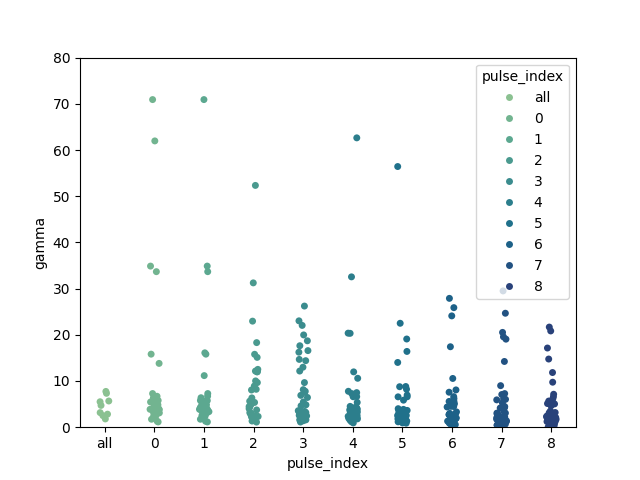

In [31]:
fig, ax = plt.subplots()
sns.stripplot(data=sdndf[(sdndf['expected']=='0') & (sdndf['sample_size']!=0)], x='pulse_index', y='gamma', hue='pulse_index', palette='crest', ax=ax)
ax.set_ylim(0, 80)
# save
fig.savefig(r'C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\paper_figures\Figure5\gamma_distribution_across_pulse_index.png', dpi=300)

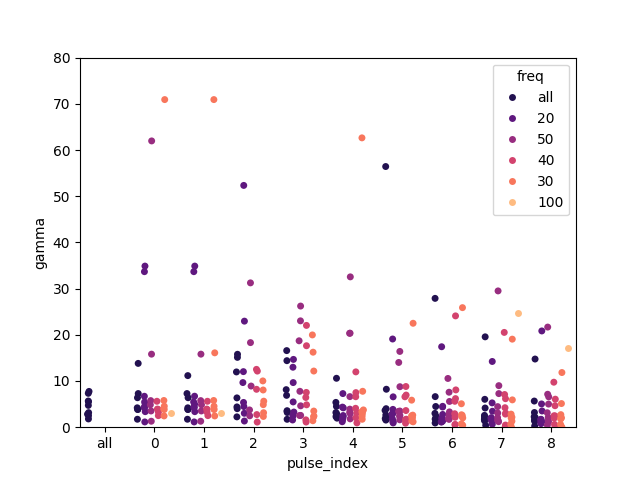

In [32]:
fig, ax = plt.subplots()
sns.stripplot(data=sdndf[(sdndf['expected']=='0') & (sdndf['sample_size']!=0)], x='pulse_index', y='gamma', hue='freq', palette='magma', dodge=True, ax=ax)
# ymin
ax.set_ylim(0, 80)
# save
fig.savefig(r'C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\paper_figures\Figure5\gamma_distribution_across_stimfreq.png', dpi=300)

In [33]:
sdndf.sample(10)

expected cellID pulse_index freq  sample_size        gamma     slope  \
31         n   4041           4  100            0          NaN       NaN   
253        0   3882           5   20            8    19.089255  0.794822   
17         0   4041           2   40            0          NaN       NaN   
442        n   3402           0  all           32     4.197454  0.335549   
245        0   3882           3  100            0          NaN       NaN   
169        n   5211           0   50            8  4004.000000  1.271629   
106        0   5611           8   20            8     1.709029  0.351463   
115        n   5291           0   40            8     5.613081  0.688577   
524        n   2331           4   40            0          NaN       NaN   
328        n   3872           8   40            8    -0.058638 -0.006448   

        r2_sdn     r2_lin  
31         NaN        NaN  
253   0.683599   0.473137  
17         NaN        NaN  
442  -0.666390  -2.995262  
245        NaN        NaN  
169   0.700623   0.853680  
106   0.482965   0.702795  
115 -11.590760 -17.199189  
524        NaN        NaN  
328  -0.000091  -0.016639

In [34]:
# make a heatmap of gamma values, where x-axis is pulse_index and y-axis is freq, for each pulse_index, freq combination, take mean of the gamma values
# first get the mean values when grouped by freq and pulse_index
mean_gamma = sdndf[(sdndf['expected']=='0') & (sdndf['sample_size']!=0)& (sdndf['freq']!=100)].copy()
# remove all the rows which have gamma is either above 80 or nan
mean_gamma = mean_gamma[(mean_gamma['gamma']<80) & (mean_gamma['gamma']>0)]
# make all the columns numeric
mean_gamma['gamma'] = pd.to_numeric(mean_gamma['gamma'])
#change pulse_index and freq to numeric, replace 'all' with 1000
mean_gamma['pulse_index']   = mean_gamma['pulse_index'].replace('all', 1000).astype('float32')
mean_gamma['cellID']        = mean_gamma['cellID'].replace('all', 1000).astype('float32')
mean_gamma['freq']          = mean_gamma['freq'].replace('all', 1000).astype('float32')
# in the column expectated, replace 'n' with 1 and '0' with 0
mean_gamma['expected'] = mean_gamma['expected'].replace('n', 1).astype('float32')
mean_gamma['expected'] = mean_gamma['expected'].replace('0', 0).astype('float32')

<Axes: xlabel='pulse_index', ylabel='freq'>

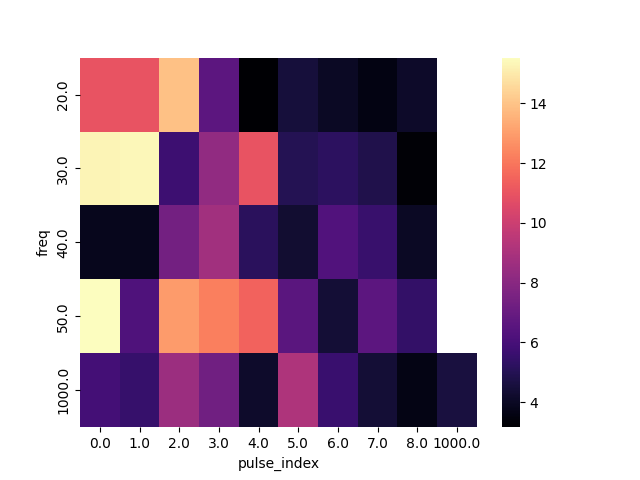

In [35]:
x = mean_gamma.groupby(['pulse_index', 'freq']).mean().reset_index()
# make a seaborn heatmap with x axis pulse_index and y axis as freq
# pivot the dataframe
x = x.pivot(index='freq', columns='pulse_index', values='gamma')
fig, ax = plt.subplots()
sns.heatmap(x, cmap='magma', ax=ax)

<Axes: xlabel='pulse_index', ylabel='gamma'>

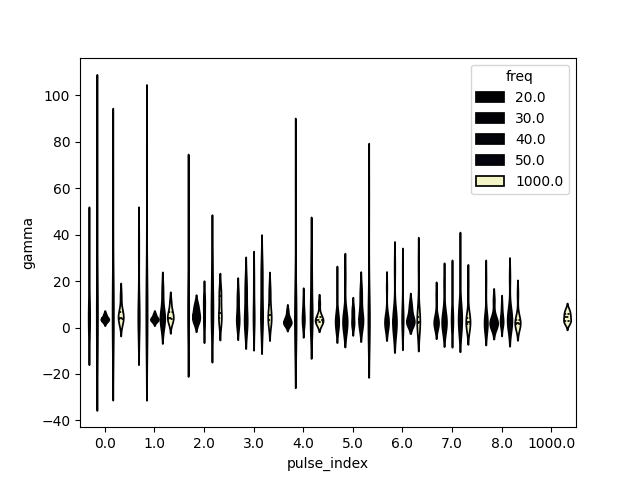

In [36]:
# make violin plots of gamma values, where x-axis is pulse_index and y-axis is gamma, hue is freq
fig, ax = plt.subplots()
sns.violinplot(data=mean_gamma, x='pulse_index', y='gamma', hue='freq', palette='magma', ax=ax, inner='quartile')

### Gamma distribution in Aanchal-Sahil's paper

<img src="notes_figures\elife-43415-fig4-v3.jpg" width=700>

<Axes: xlabel='gamma', ylabel='Count'>

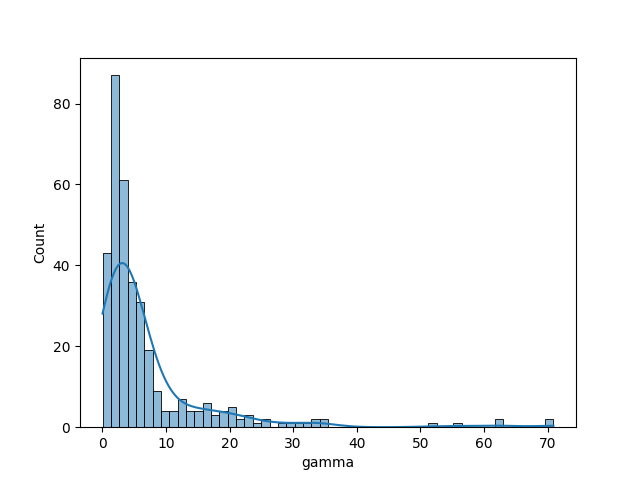

In [37]:
# histogram of all gama values
fig, ax = plt.subplots()
sns.histplot(data=mean_gamma, x='gamma', kde=True, ax=ax)

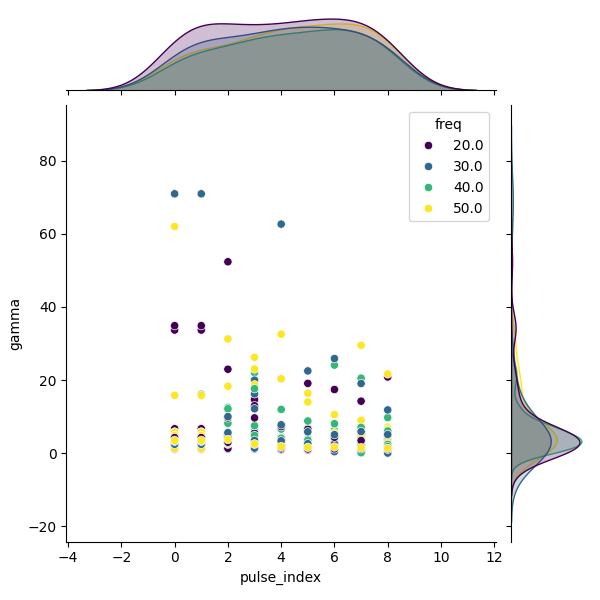

In [38]:
g = sns.jointplot(
    data=mean_gamma[(mean_gamma['freq']!=1000) & (mean_gamma['pulse_index']!=1000)],
    x="pulse_index", y="gamma", hue='freq',
    kind="scatter",palette='viridis' #'scatter', 'hist', 'hex', 'kde', 'reg', 'resid'
)

C:\Users\adity\AppData\Local\Temp\ipykernel_18972\3892699593.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp['gamma'] = pd.to_numeric(dftemp['gamma'])
C:\Users\adity\AppData\Local\Temp\ipykernel_18972\3892699593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp['pulse_index']   = dftemp['pulse_index'].replace('all', 1000).astype('float32')
C:\Users\adity\AppData\Local\Temp\ipykernel_18972\3892699593.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

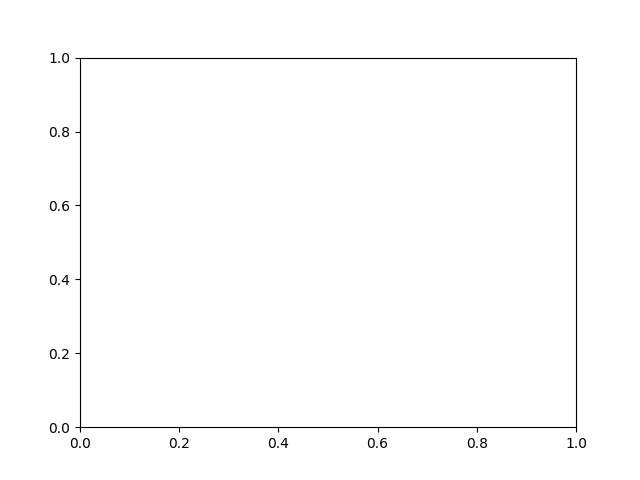

In [39]:
# get a histgram of first pulse gamma values for each cell
fig, ax = plt.subplots()
dftemp = sdndf[(sdndf['sample_size']!=0) & (sdndf['pulse_index']!='all') & (sdndf['gamma']<80) & (sdndf['gamma']>0)]
# dftemp = dftemp[]
# make all the columns numeric
dftemp['gamma'] = pd.to_numeric(dftemp['gamma'])
#change pulse_index and freq to numeric, replace 'all' with 1000
dftemp['pulse_index']   = dftemp['pulse_index'].replace('all', 1000).astype('float32')
dftemp['cellID']        = dftemp['cellID'].replace('all', 1000).astype('float32')
dftemp['freq']          = dftemp['freq'].replace('all', 1000).astype('float32')
# in the column expectated, replace 'n' with 1 and '0' with 0
dftemp['expected'] = dftemp['expected'].replace('n', 1).astype('float32')
dftemp['expected'] = dftemp['expected'].replace('0', 0).astype('float32')

In [ ]:
dftemp = dftemp.groupby('cellID').mean().reset_index()
# make a histogram of gamma values
fig, ax = plt.subplots()
sns.histplot(data=dftemp, x='gamma', kde=False, ax=ax, binwidth=2)

In [ ]:
g = np.tile(list("0123456789"), 50)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(dftemp, row="pulse_index", hue="pulse_index", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "gamma",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "gamma", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color, fontsize=8,  
                  ha="left", va="center", transform=ax.transAxes, zorder=10)

g.map(label, "gamma")